In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import cv2
import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [3]:
%pip install seaborn

  Obtaining dependency information for seaborn from https://files.pythonhosted.org/packages/7b/e5/83fcd7e9db036c179e0352bfcd20f81d728197a16f883e7b90307a88e65e/seaborn-0.13.0-py3-none-any.whl.metadata
  Using cached seaborn-0.13.0-py3-none-any.whl.metadata (5.3 kB)
  Obtaining dependency information for matplotlib!=3.6.1,>=3.3 from https://files.pythonhosted.org/packages/59/e2/6b155713e8da8274367b41315b66260f9d3c52d9f4b26336ddc3986ba612/matplotlib-3.8.1-cp311-cp311-win_amd64.whl.metadata
  Using cached matplotlib-3.8.1-cp311-cp311-win_amd64.whl.metadata (5.9 kB)
  Obtaining dependency information for contourpy>=1.0.1 from https://files.pythonhosted.org/packages/ca/2a/d197a412ec474391ee878b1218cf2fe9c6e963903755887fc5654c06636a/contourpy-1.2.0-cp311-cp311-win_amd64.whl.metadata
  Using cached contourpy-1.2.0-cp311-cp311-win_amd64.whl.metadata (5.8 kB)
  Obtaining dependency information for cycler>=0.10 from https://files.pythonhosted.org/packages/e7/05/c19819d5e3d95294a6f5947fb9b9629efb3

In [2]:
IMAGE_SIZE = 128
BATCH_SIZE = 32
CHANNELS = 3

In [3]:
def read_and_preprocess(img_path):
    img = cv2.imread(img_path, cv2.IMREAD_COLOR) # reading the image
    img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE)) # resizing it to 128*128
    img = np.array(img, dtype='float32') # convert its datatype so that it could be normalized
    img = img/255 # normalization (now every pixel is in the range of 0 and 1)
    return img

In [4]:
labels = ['real', 'fake']

X = [] # To store images
y = [] # To store labels
image_path = 'dataset' # path containing image samples

In [5]:
for folder in os.scandir(image_path):
    for entry in os.scandir(os.path.join(image_path, folder.name)):
        # Construct the full file path using os.path.join
        file_path = os.path.join(image_path, folder.name, entry.name)
        
        processed_image = read_and_preprocess(file_path)
        
        # Check if the image was successfully processed
        if processed_image is not None:
            X.append(processed_image)
            
            # Label the images (0 for real, 1 for fake)
            if folder.name[0] == 'r':
                y.append(0)  # real
            else:
                y.append(1)  # fake

In [16]:
for folder in os.scandir(image_path):
    for entry in os.scandir(os.path.join(image_path, folder.name)):
        # Construct the full file path using os.path.join
        file_path = os.path.join(image_path, folder.name, entry.name)
        print(file_path)

dataset\fake\fake_1.jpg
dataset\fake\fake_10.jpg
dataset\fake\fake_100.jpg
dataset\fake\fake_101.jpg
dataset\fake\fake_102.jpg
dataset\fake\fake_103.jpg
dataset\fake\fake_104.jpg
dataset\fake\fake_105.jpg
dataset\fake\fake_106.jpg
dataset\fake\fake_107.jpg
dataset\fake\fake_108.jpg
dataset\fake\fake_109.jpg
dataset\fake\fake_11.jpg
dataset\fake\fake_110.jpg
dataset\fake\fake_111.jpg
dataset\fake\fake_112.jpg
dataset\fake\fake_113.jpg
dataset\fake\fake_114.jpg
dataset\fake\fake_115.jpg
dataset\fake\fake_116.jpg
dataset\fake\fake_117.jpg
dataset\fake\fake_118.jpg
dataset\fake\fake_119.jpg
dataset\fake\fake_12.jpg
dataset\fake\fake_120.jpg
dataset\fake\fake_121.jpg
dataset\fake\fake_122.jpg
dataset\fake\fake_123.jpg
dataset\fake\fake_124.jpg
dataset\fake\fake_125.jpg
dataset\fake\fake_126.jpg
dataset\fake\fake_127.jpg
dataset\fake\fake_128.jpg
dataset\fake\fake_129.jpg
dataset\fake\fake_13.jpg
dataset\fake\fake_130.jpg
dataset\fake\fake_131.jpg
dataset\fake\fake_132.jpg
dataset\fake\fake_

In [6]:
X = np.array(X)
X.shape

(1289, 128, 128, 3)

In [7]:
y = np.array(y)
y.shape

(1289,)

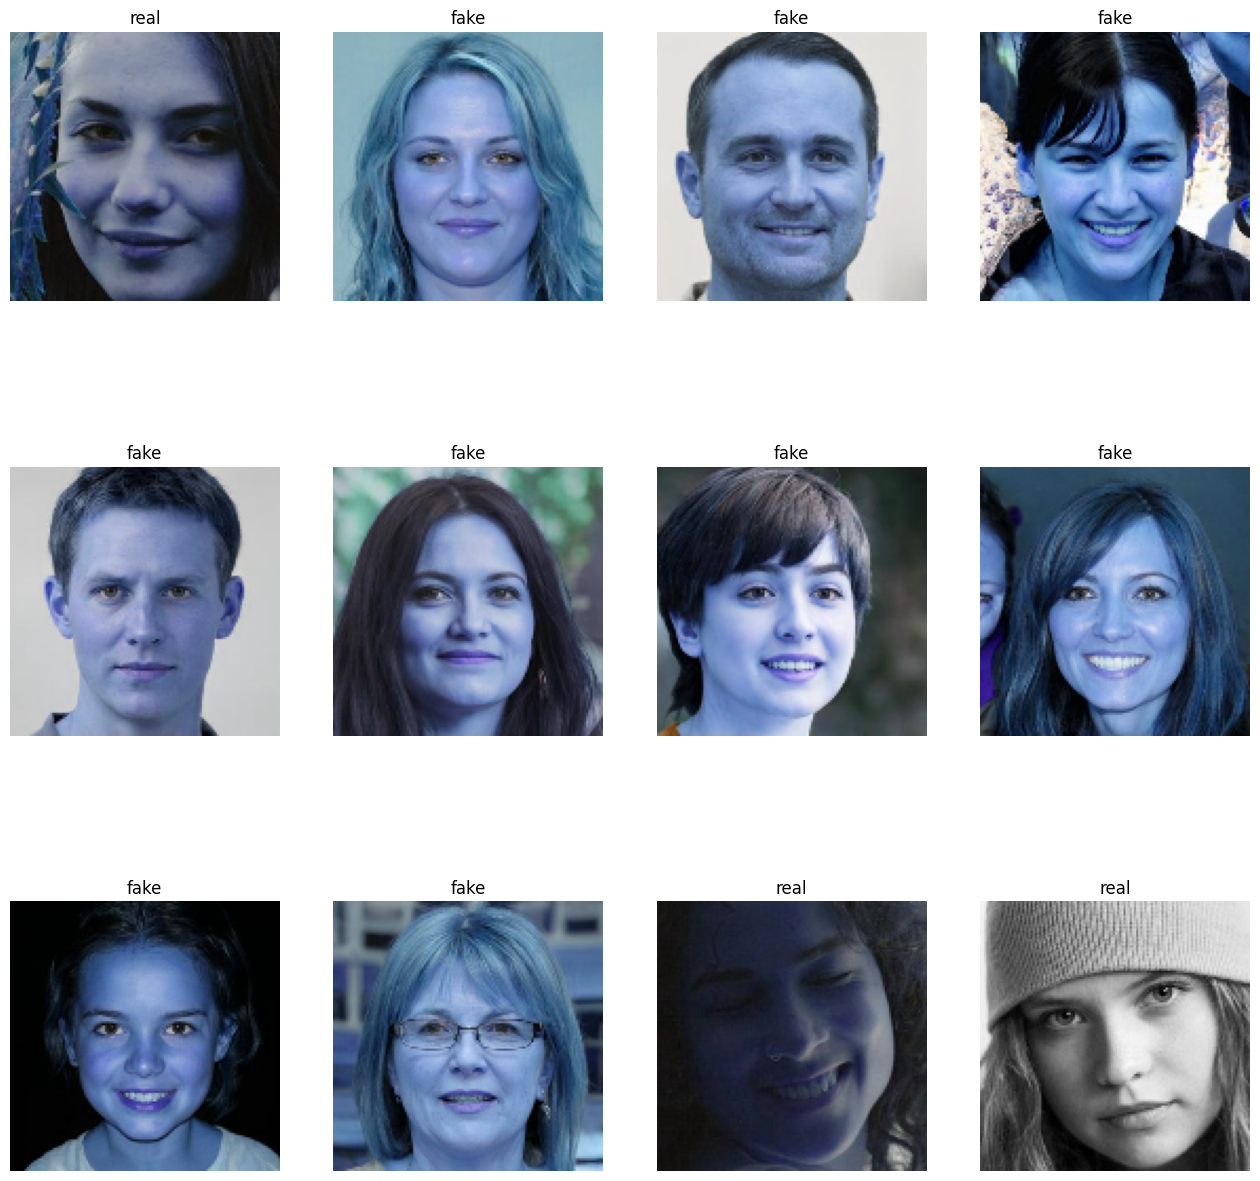

In [8]:
import random

plt.figure(figsize=(16, 16))

for i in range(12):
    ax = plt.subplot(3, 4, i + 1)
    plt.axis("off")
    img = random.randint(0, 1289)
    plt.imshow(X[img])
    plt.title(labels[y[img]])


In [9]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, 
                                                  test_size=0.2, 
                                                  shuffle=True, 
                                                  stratify=y, 
                                                  random_state=123)

In [10]:
X_train.shape

(1031, 128, 128, 3)

In [11]:
X_test, X_val, y_test, y_val = train_test_split(X_val, y_val, 
                                                  test_size=0.5, 
                                                  shuffle=True, 
                                                  stratify=y_val, 
                                                  random_state=123)

In [12]:
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 2

model = tf.keras.Sequential([
    Conv2D(filters=32, kernel_size=(2,2), activation='relu', input_shape=input_shape),
    MaxPooling2D((4,4)),
    
    Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same'),
    MaxPooling2D((3,3)),
    Dropout(0.3), # for regularization
    
    Conv2D(filters=64, kernel_size=(4,4), activation='relu', padding='same'),
    Conv2D(filters=128, kernel_size=(5,5), activation='relu', padding='same'),
    MaxPooling2D((2,2)),
    Dropout(0.4),
    
    Conv2D(filters=128, kernel_size=(5,5), activation='relu', padding='same'),
    MaxPooling2D((2,2)),
    Dropout(0.5),
    
    Flatten(), # flattening for feeding into ANN
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dense(n_classes, activation='softmax')
])

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 127, 127, 32)      416       
                                                                 
 max_pooling2d (MaxPooling2  (None, 31, 31, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 31, 31, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 10, 10, 64)        0         
 g2D)                                                            
                                                                 
 dropout (Dropout)           (None, 10, 10, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 10, 10, 64)        6

In [14]:
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("No GPU devices found.")

No GPU devices found.


In [15]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [21]:
model.compile(loss = 'sparse_categorical_crossentropy', optimizer='Adam', metrics= ["accuracy"])

In [22]:
# use early stopping to exit training if validation loss is not decreasing even after certain epochs (patience)
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

# save the best model with least validation loss
checkpointer = ModelCheckpoint(filepath="fakevsreal_weights.h5", verbose=1, save_best_only=True)

In [23]:
history = model.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val), batch_size=BATCH_SIZE, shuffle=True, callbacks=[earlystopping, checkpointer])

Epoch 1/100
32/33 [============================>.] - ETA: 0s - loss: 0.7009 - accuracy: 0.5205
Epoch 1: val_loss improved from inf to 0.69109, saving model to fakevsreal_weights.h5
33/33 [==============================] - 8s 157ms/step - loss: 0.7009 - accuracy: 0.5209 - val_loss: 0.6911 - val_accuracy: 0.5426


d:\AIM-FERDAWS\deepcomputervison\venv\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/100
33/33 [==============================] - ETA: 0s - loss: 0.6911 - accuracy: 0.5432
Epoch 2: val_loss improved from 0.69109 to 0.68874, saving model to fakevsreal_weights.h5
33/33 [==============================] - 6s 171ms/step - loss: 0.6911 - accuracy: 0.5432 - val_loss: 0.6887 - val_accuracy: 0.5426
Epoch 3/100
33/33 [==============================] - ETA: 0s - loss: 0.6698 - accuracy: 0.5917
Epoch 3: val_loss improved from 0.68874 to 0.58378, saving model to fakevsreal_weights.h5
33/33 [==============================] - 8s 255ms/step - loss: 0.6698 - accuracy: 0.5917 - val_loss: 0.5838 - val_accuracy: 0.6667
Epoch 4/100
33/33 [==============================] - ETA: 0s - loss: 0.6307 - accuracy: 0.6275
Epoch 4: val_loss improved from 0.58378 to 0.56177, saving model to fakevsreal_weights.h5
33/33 [==============================] - 8s 232ms/step - loss: 0.6307 - accuracy: 0.6275 - val_loss: 0.5618 - val_accuracy: 0.6899
Epoch 5/100
33/33 [==============================] -

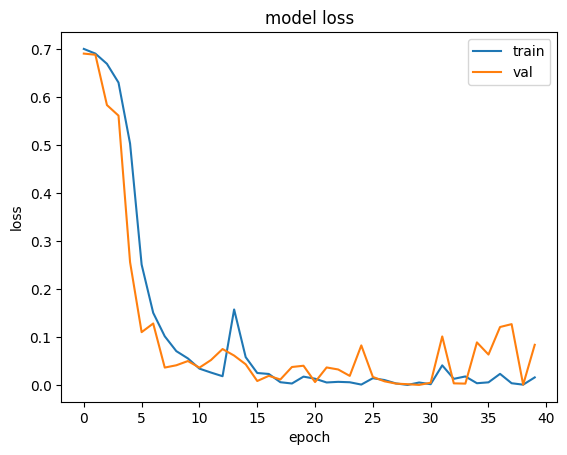

In [24]:
# The is how training loss and validation loss varied during training
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [26]:
model.save("fakevsreal_model.h5")

In [27]:
from tensorflow.keras.models import load_model

model = load_model("fakevsreal_model.h5") 
model.load_weights('fakevsreal_weights.h5')
model.compile(loss = 'sparse_categorical_crossentropy', optimizer='Adam', metrics= ["accuracy"])

In [28]:
predictions = model.predict(X_test)

5/5 [==============================] - 0s 44ms/step


In [33]:
predict = []

for i in predictions:
  predict.append(np.argmax(i))

predict = np.asarray(predict)
  # Convert probabilities to binary predictions

In [36]:
from sklearn.metrics import accuracy_score, classification_report
accuracy = accuracy_score(y_test, predict)
print("Accuracy:", accuracy)


Accuracy: 0.9844961240310077


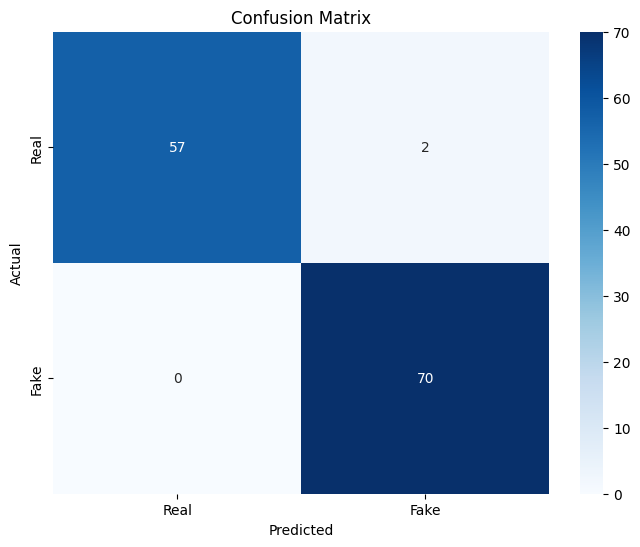

In [38]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming predictions and y_test are available
conf_matrix = confusion_matrix(y_test, predict)

# Create a heatmap for the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', 
            xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()